In [4]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
%load_ext tensorboard

In [5]:
shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))

features_shared_MACCS = np.load(os.path.join("features", "shared_set_features_MACCS.npy"))
features_only_2c9_MACCS = np.load(os.path.join("features", "only_2c9_set_features_MACCS.npy"))
features_only_3a4_MACCS = np.load(os.path.join("features", "only_3a4_set_features_MACCS.npy"))

features_shared_RDKIT = np.load(os.path.join("features", "shared_set_features_RDKIT.npy"))
features_only_2c9_RDKIT = np.load(os.path.join("features", "only_2c9_set_features_RDKIT.npy"))
features_only_3a4_RDKIT = np.load(os.path.join("features", "only_3a4_set_features_RDKIT.npy"))

all_features = [features_shared, features_shared_RDKIT, features_shared_MACCS]
all_features_only_2c9 = [features_only_2c9, features_only_2c9_RDKIT, features_only_2c9_MACCS]

In [8]:
np.hstack(all_features[:3]).shape

(9420, 3239)

In [6]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_evolution(val, test):
    fig, axes = plt.subplots(1, 1, figsize=(18, 8))
    lines = axes.plot(val, "x-")
    lines += axes.plot(test, "o-")
    axes.legend(lines, ["Acc. val", "MCC val", "Acc. test", "MCC test"], fontsize=16)
    axes.set_xticks([0, 1, 2])
    axes.set_xticklabels(["Morgan", "Morgan+RDKIT", "Morgan+RDKIT+MACCS"], rotation=90, fontsize=16);
    axes.grid()
    
def test_sizes_set_SVM(labels, features_list, features_only_list, labels_testing):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    for i in range(1, len(features_list)+1):
        features = np.hstack(features_list[:i])
        features_only = np.hstack(features_only_list[:i])
        model = SVC(C=20, kernel="rbf")
        train_data, val_data, train_labels, val_labels = train_test_split(features, labels, stratify=labels)
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels)
        predictions = model.predict(val_data)
        print(f"Metrics with {i} features sets with {features.shape[1]} features, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with {i} features sets with {features_only.shape[1]} features, testing set, random ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)  
    return results_test, results_validation

In [24]:
res_test, res_val = test_sizes_set_SVM(labels_2c9, all_features, all_features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with 1 features sets with 1024 features, validation set, random ligands
NER: 0.796, Sensitivity or recall: 0.707, Specificity: 0.886, Precision: 0.746, Correctly classified: 0.828, MCC: 0.602
Metrics with 1 features sets with 1024 features, testing set, random ligands
NER: 0.738, Sensitivity or recall: 0.624, Specificity: 0.852, Precision: 0.704, Correctly classified: 0.770, MCC: 0.490
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
Metrics with 2 features sets with 3072 features, validation set, random ligands
NER: 0.804, Sensitivity or recall: 0.715, Specificity: 0.892, Precision: 0.759, Correctly classified: 0.835, MCC: 0.617
Metrics with 2 features sets with 3072 features, testing set, random ligands
NER: 0.735, Sensitivity or recall: 0.633, Specificity: 0.838, Precision: 0.688, Correctly classified: 0.764, MCC: 0.480
Propor

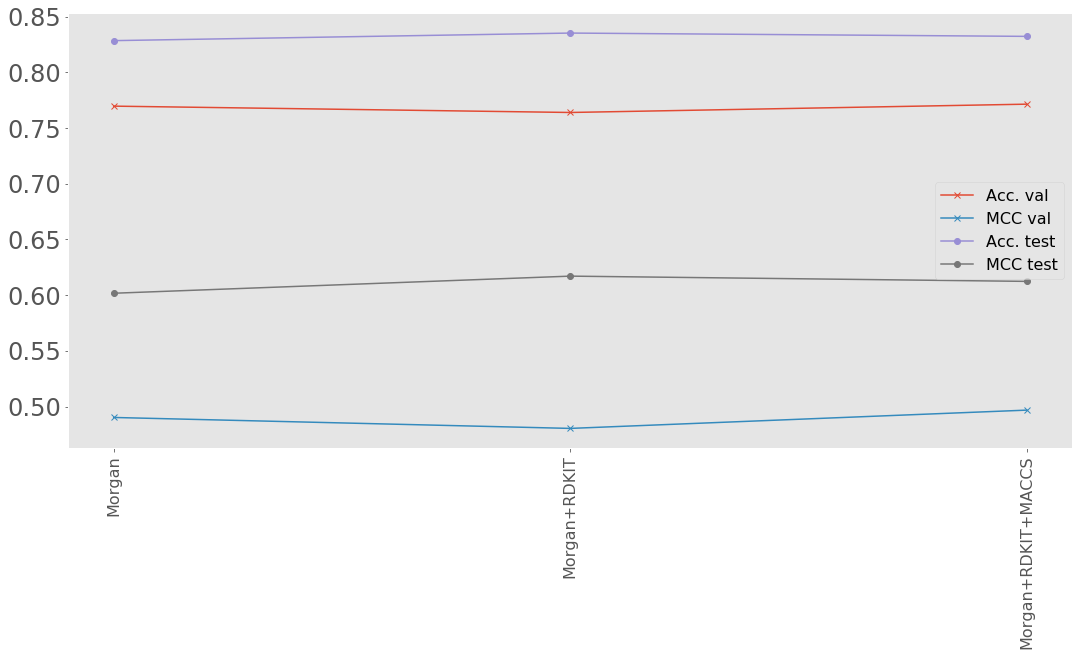

In [29]:
plot_evolution(res_test, res_val)

In [15]:
combined_features = np.hstack(all_features)
combined_features_only_2c9 = np.hstack(all_features_only_2c9)

In [35]:
percentiles = list(range(5,101,5))
n_features = []
results_validation = []
results_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(combined_features, labels_2c9)
    only_2c9_reduced = feat_select.transform(combined_features_only_2c9)
    n_features.append(train_data.shape[1])
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    model = SVC(C=20, kernel="rbf")
    history = model.fit(train_data, train_labels)
    predictions = model.predict(val_data)
    results_validation.append(print_metrics(predictions, val_labels))
    predictions = model.predict(only_2c9_reduced)
    results_test.append(print_metrics(predictions, labels_testing_2c9))  


NER: 0.776, Sensitivity or recall: 0.682, Specificity: 0.870, Precision: 0.713, Correctly classified: 0.809, MCC: 0.558
NER: 0.707, Sensitivity or recall: 0.594, Specificity: 0.819, Precision: 0.649, Correctly classified: 0.738, MCC: 0.422
NER: 0.776, Sensitivity or recall: 0.684, Specificity: 0.867, Precision: 0.710, Correctly classified: 0.808, MCC: 0.557
NER: 0.719, Sensitivity or recall: 0.610, Specificity: 0.828, Precision: 0.667, Correctly classified: 0.749, MCC: 0.448
NER: 0.787, Sensitivity or recall: 0.699, Specificity: 0.875, Precision: 0.726, Correctly classified: 0.818, MCC: 0.580
NER: 0.720, Sensitivity or recall: 0.604, Specificity: 0.836, Precision: 0.676, Correctly classified: 0.753, MCC: 0.453
NER: 0.770, Sensitivity or recall: 0.663, Specificity: 0.877, Precision: 0.719, Correctly classified: 0.808, MCC: 0.553
NER: 0.708, Sensitivity or recall: 0.597, Specificity: 0.818, Precision: 0.650, Correctly classified: 0.738, MCC: 0.424
NER: 0.787, Sensitivity or recall: 0.696

Text(0.5, 0, 'Number features kept')

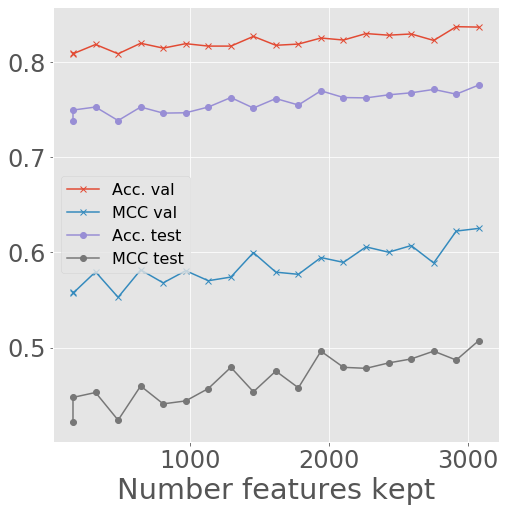

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
lines = axes.plot(n_features, results_validation, "x-")
lines += axes.plot(n_features, results_test, "o-")
axes.legend(lines, ["Acc. val", "MCC val", "Acc. test", "MCC test"], fontsize=16)
axes.set_xlabel("Number features kept")

In [11]:
def generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_bits, activation='relu', input_shape=(n_bits,)),tf.keras.layers.Dropout(dropout)]+
        [tf.keras.layers.Dense(neurons, kernel_regularizer=tf.keras.regularizers.l2(L2),  activation="relu") for _ in range(hidden_layers)]+
        [tf.keras.layers.Dense(1, activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"))
    return model

def test_sizes_set_NN(hidden_layers, neurons, dropout, optimizer, L2, labels, features_list, features_only_list, labels_testing):   
    # columns are: accuracy, MCC
    results_test = []
    results_validation = []
    for i in range(1, len(features_list)+1):
        features = np.hstack(features_list[:i])
        n_bits = features.shape[1]
        model = generate_model(hidden_layers, neurons, dropout, optimizer, L2, n_bits)
        features_only = np.hstack(features_only_list[:i])
        train_data, val_data, train_labels, val_labels = train_test_split(features, labels, stratify=labels)
        print("Proportion actives in validation:", np.sum(val_labels)/len(val_labels), "Proportion actives in train:", np.sum(train_labels)/len(train_labels))
        history = model.fit(train_data, train_labels)
        predictions = model.predict(val_data)
        print(f"Metrics with {i} features sets with {features.shape[1]} features, validation set, random ligands")
        res_val = print_metrics(predictions, val_labels);
        results_validation.append(res_val)
        print(f"Metrics with {i} features sets with {features_only.shape[1]} features, testing set, random ligands")
        predictions = model.predict(features_only)
        res_test = print_metrics(predictions, labels_testing);
        results_test.append(res_test)  
    return results_test, results_validation

In [12]:
hidden_layers = 4
neurons = 160
dropout = 0.5
lr = 0.1
# opt  = tf.keras.optimizers.Adam(lr=lr)
opt = tf.keras.optimizers.SGD(lr=lr)
L2 = 0.01
res_test, res_val = test_sizes_set_NN(hidden_layers, neurons, dropout, opt, L2, labels_2c9, all_features, all_features_only_2c9, labels_testing_2c9)

Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
221/221 [==============================] - 2s 7ms/step - loss: 5.6427 - binary_accuracy: 0.6849
Metrics with 1 features sets with 1024 features, validation set, random ligands
NER: 0.634, Sensitivity or recall: 0.312, Specificity: 0.956, Precision: 0.771, Correctly classified: 0.749, MCC: 0.372
Metrics with 1 features sets with 1024 features, testing set, random ligands
NER: 0.595, Sensitivity or recall: 0.250, Specificity: 0.940, Precision: 0.704, Correctly classified: 0.691, MCC: 0.274
Proportion actives in validation: 0.3214437367303609 Proportion actives in train: 0.321585279547063
221/221 [==============================] - 5s 23ms/step - loss: 5.7841 - binary_accuracy: 0.7056
Metrics with 2 features sets with 3072 features, validation set, random ligands
NER: 0.676, Sensitivity or recall: 0.411, Specificity: 0.941, Precision: 0.768, Correctly classified: 0.771, MCC: 0.436
Metrics wi

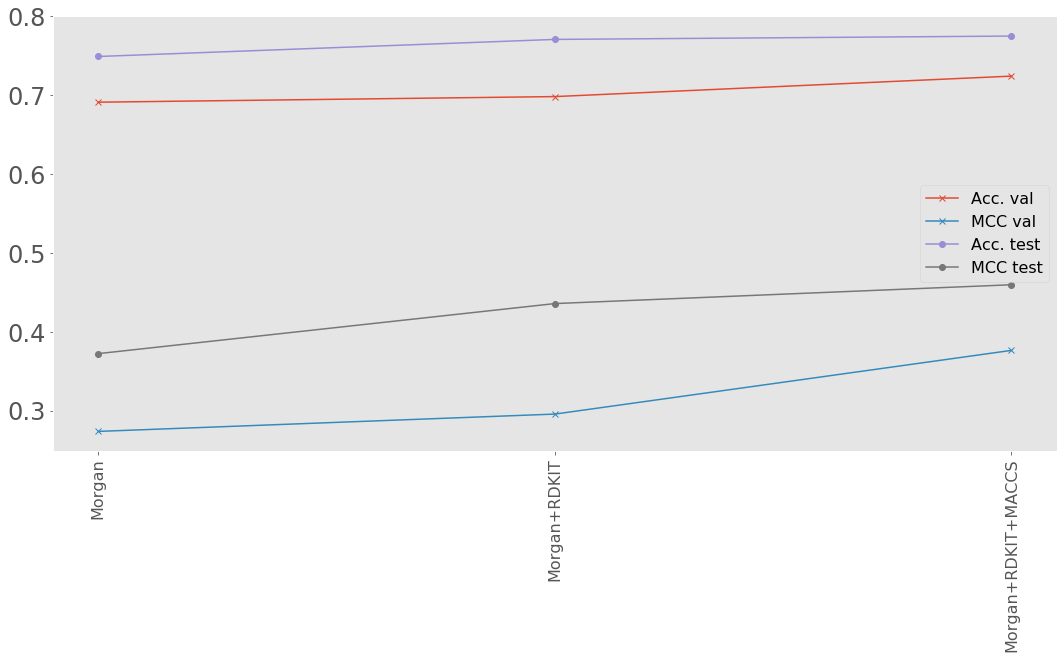

In [13]:
plot_evolution(res_test, res_val)

In [19]:
percentiles = list(range(5,101,5))
n_features = []
results_validation = []
results_test = []
for percentile in percentiles:
    feat_select = SelectPercentile(chi2, percentile=percentile)
    shared_reduced = feat_select.fit_transform(combined_features, labels_2c9)
    only_2c9_reduced = feat_select.transform(combined_features_only_2c9)
    train_data, val_data, train_labels, val_labels = train_test_split(shared_reduced, labels_2c9, stratify=labels_2c9)
    n_features.append(train_data.shape[1])
    n_bits = train_data.shape[1]
    model = generate_model(hidden_layers, neurons, dropout, opt, L2, n_bits)
    history = model.fit(train_data, train_labels)
    predictions = model.predict(val_data)
    results_validation.append(print_metrics(predictions, val_labels))
    predictions = model.predict(only_2c9_reduced)
    results_test.append(print_metrics(predictions, labels_testing_2c9))  


221/221 [==============================] - 1s 4ms/step - loss: 4.8297 - binary_accuracy: 0.6984
NER: 0.567, Sensitivity or recall: 0.166, Specificity: 0.967, Precision: 0.704, Correctly classified: 0.710, MCC: 0.235
NER: 0.551, Sensitivity or recall: 0.138, Specificity: 0.964, Precision: 0.683, Correctly classified: 0.665, MCC: 0.188
221/221 [==============================] - 1s 4ms/step - loss: 5.1828 - binary_accuracy: 0.7086
NER: 0.654, Sensitivity or recall: 0.404, Specificity: 0.904, Precision: 0.667, Correctly classified: 0.744, MCC: 0.364
NER: 0.602, Sensitivity or recall: 0.336, Specificity: 0.868, Precision: 0.589, Correctly classified: 0.675, MCC: 0.241
221/221 [==============================] - 1s 5ms/step - loss: 5.3642 - binary_accuracy: 0.7138
NER: 0.713, Sensitivity or recall: 0.572, Specificity: 0.855, Precision: 0.651, Correctly classified: 0.764, MCC: 0.443
NER: 0.653, Sensitivity or recall: 0.487, Specificity: 0.818, Precision: 0.602, Correctly classified: 0.699, MCC

Text(0.5, 0, 'Number features kept')

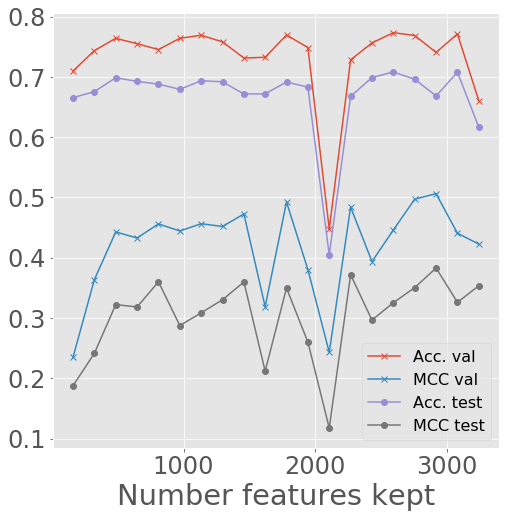

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
lines = axes.plot(n_features, results_validation, "x-")
lines += axes.plot(n_features, results_test, "o-")
axes.legend(lines, ["Acc. val", "MCC val", "Acc. test", "MCC test"], fontsize=16)
axes.set_xlabel("Number features kept")